### This is the Project One for my Udacity Data Scientist Nano Degree training program 

For this project, I used the Seattle Airbnb dataset provided by Udacity and performed the analytical work via the data science process. 

##Business Understanding 

In modern days, Airbnb has taken over the traditional hotel businesses as an alternative way for travelers to choose their logding while visiting a new city. Seattle is one of the most attractive cities to visit on the US west coast. Therefore, it will be intereting to gain insights on the best area to release an Airbnb place in the city of Seattle. 

There are 3 questions I am interested to answer: 
Question 1 - which listing ID receives the most reviews? the highest avergae price listed? 
Question 2 - which zipecode area in Seattle receives the highest review rating? 
Question 3 - what are the more relevant features to predict the pricing? 

##  Data gathering 

I imported mutiple common Python libraries known for data preparation
I then created distinct dataframes to cover the 3 data files provided. 

In [13]:
# Import and read the files 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Build dataframes for the data file
df_calendar = pd.read_csv('./Downloads/Seattle_Airbnb_data/calendar.csv') 
df_listing = pd.read_csv('./Downloads/Seattle_Airbnb_data/listings.csv')
df_reviews = pd.read_csv('./Downloads/Seattle_Airbnb_data/reviews.csv') 


## Data assessment

Using calendar data as an exmple, I ran a few commands to have a better understanding of the data, such unique value per column, the number of null value in each column, etc. 

In [17]:
#Checking Calendar dataset

df_calendar.nunique() # Check the unique value per column 
df_calendar.isnull().sum() # Check the NaN counts per column
df_calendar.head() 

df_listing.columns.tolist() # Provide the full column headings


['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',


## Data cleaning 

This is the stage I spent a fair amount of time after reviewing each data file carefully and identifying the data I need to either modify (i.e., the format) and clean (i.e., treat null value). 

For example, I built a clean_currency function to covert the Price column from string to float. So I can later calculate the average price per listing ID. 

In [4]:
#Convert price column from object to float

def clean_currency(x): 
    """As Price is a string, need to remove $ sign and comma delimiter"""
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

df_calendar['listing_id'] = df_calendar['listing_id'].astype(str)
df_calendar['date'] = df_calendar['date'].astype('datetime64[ns]')
df_calendar['price'] = df_calendar['price'].apply(clean_currency).astype(float)


## Data analysis 

This is where the fun begins - after needed data maninuplation I was able to answer the questions I am interested. 

1) I created a new dataframe using groupby to calculate the average price by each listing ID when the unit is avaialble from the Calendar file.

2) Similarly, I created another dataframe showing the review counts by listing ID from the reviewer file. 

3) I combined these 2 dataframes by listing ID. 

4) I then can review either the reviewer counts or average pricing per listing ID in descending order.

In [7]:
#drop NA price rows and calculate the average price by list_id when the unit is available 
df_calendar_new = df_calendar[df_calendar.available=='t'].groupby('listing_id')['price'].mean().reset_index(name='avg_price')
df_calendar_new.head(10)

,listing_id,avg_price
0,10000273,182.080925
1,1000883,102.916667
2,10012724,25.000000
3,10019082,131.696629
4,10020221,55.000000
5,10022421,74.000000
6,10023353,131.950673
7,10026648,65.000000
8,1002835,134.205479
9,10031055,30.402439


In [8]:
#Explore Reviews dataset
df_reviews.nunique()
df_reviews['listing_id'] = df_reviews['listing_id'].astype(str)
df_reviews_new = df_reviews.groupby('listing_id')['reviewer_id'].count().reset_index(name = 'reviewer_count')
df_reviews_new.head(10)

,listing_id,reviewer_count
0,1000883,18
1,10012724,2
2,10020221,1
3,1002835,6
4,1003890,72
5,1009838,56
6,10118341,1
7,1012003,12
8,1018204,79
9,1022135,7


## Question 1 part A - which listing ID recieves the most review?  

I merged the Calendar and Review data files by listing ID, so I can find the answers for the first 2 questions. 

After merging, I sorted the count of reviewers by listing IDs first. 

In [9]:
#Merge between calendar and review datasets by listing IDs
df_match = pd.merge(df_calendar_new, df_reviews_new, on=['listing_id'], how='left')
df_match['reviewer_count'] = df_match['reviewer_count'].fillna(0)
df_match.sort_values(by='reviewer_count', ascending=False) 

,listing_id,avg_price,reviewer_count
450,208356,102.682353,474.0
899,365550,102.778816,466.0
551,25002,78.084416,404.0
1345,47196,67.816092,353.0
1879,63308,97.813869,320.0
...,...,...,...
2894,8156764,42.000000,0.0
2895,8156860,42.000000,0.0
2896,8156894,42.000000,0.0
2897,8157486,52.849315,0.0


By ranking the count of reviewers by listing IDs, 208356 shows the highest reviewer count of 474 times. 

## Question 1 part b - which listing id asks for the highest average price? 

Now I sorted the average price by listing price in descendind order.  

In [10]:
df_match.sort_values(by='avg_price', ascending=False) 

,listing_id,avg_price,reviewer_count
781,3308979,1301.818182,20.0
2598,7733192,1010.977716,12.0
1383,4825073,1000.000000,1.0
610,2720963,950.000000,5.0
1237,4464824,910.270718,5.0
...,...,...,...
2226,7011773,25.000000,0.0
2,10012724,25.000000,2.0
1335,4701205,25.000000,39.0
65,10248139,21.176471,1.0


Listing ID 3308979 is shown with the highest average price of $1301.82. 

## Question 2 - which zipcode in Seattle receives the highest reviewer rating? 

I first changed the zipcode to string format, and later standardized the value to 5 digits. 
I then calculated the average review rating by zipcode, and sorted the output in descending order. 

In [11]:
# Explore listings dataset

df_listing['zipcode']=df_listing['zipcode'].astype(str) 
df_listing['zipcode']=df_listing['zipcode'].str[-5:] #Standardize zipcode to 5-digit code
df_listing_zip = df_listing.groupby('zipcode')['review_scores_rating'].mean().reset_index(name = 'avg_rating')
df_listing_zip.sort_values(by='avg_rating', ascending=False)

,zipcode,avg_rating
23,98146,98.000000
24,98177,96.600000
11,98116,96.077778
5,98106,95.882353
21,98136,95.638889
18,98126,95.574468
12,98117,95.507246
16,98122,95.413699
6,98107,95.361842
14,98119,95.361345


In [ ]:
Zip code, 98146, shows the highest average reviewer rating score of 98.  

## Question 3 - what are the more relevant features to predict pricing? 

1) After carefully reviewing all data columns provided in the listing dataset, I narrowed down the columns to a specific group based on the business knowledge. 
2) I filled the NaN cells with 0s and treated categorical variables. 
3) I ran a correlation analysis of all the variables against price. 
4) I created a heatmap to show the correlation results. 

In [5]:
# select important columns from listing dataset 
df_listing_new = df_listing[['neighbourhood_group_cleansed', 'zipcode', 'property_type',
                             'room_type', 'accommodates', 'bathrooms', 'bedrooms',
                             'price', 'beds', 'bed_type','review_scores_rating']].copy()

df_listing_new['price'] = df_listing_new['price'].apply(clean_currency).astype(float)
df_listing_clean = df_listing_new.fillna(0)

In [6]:
#Create a new dataframe by treating categorical columns
df_listing_clean = df_listing_clean.dropna(subset=['price'], axis=0)

cat_df = df_listing_clean.select_dtypes(include=['object'])

cat_cols_list = cat_df.columns

def create_dummy_df(df, cat_cols, dummy_na):
    for col in cat_cols_list:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

df_new = create_dummy_df(df_listing_clean, cat_cols_list, dummy_na=False)

df_new.describe()


,accommodates,bathrooms,bedrooms,price,beds,review_scores_rating,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,...,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.00000,3818.000000
mean,3.349398,1.254191,1.305657,127.976166,1.734940,78.518596,0.030906,0.148507,0.023311,0.096647,...,0.001310,0.030906,0.000786,0.000262,0.303824,0.030644,0.003405,0.019382,0.01231,0.957831
std,1.977599,0.594724,0.884219,90.250022,1.139677,35.979061,0.173086,0.355648,0.150908,0.295516,...,0.036169,0.173086,0.028024,0.016184,0.459968,0.172375,0.058260,0.137881,0.11028,0.201000
min,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.000000,1.000000,1.000000,75.000000,1.000000,87.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,3.000000,1.000000,1.000000,100.000000,1.000000,95.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,4.000000,1.000000,2.000000,150.000000,2.000000,98.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000
max,16.000000,8.000000,7.000000,1000.000000,15.000000,100.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


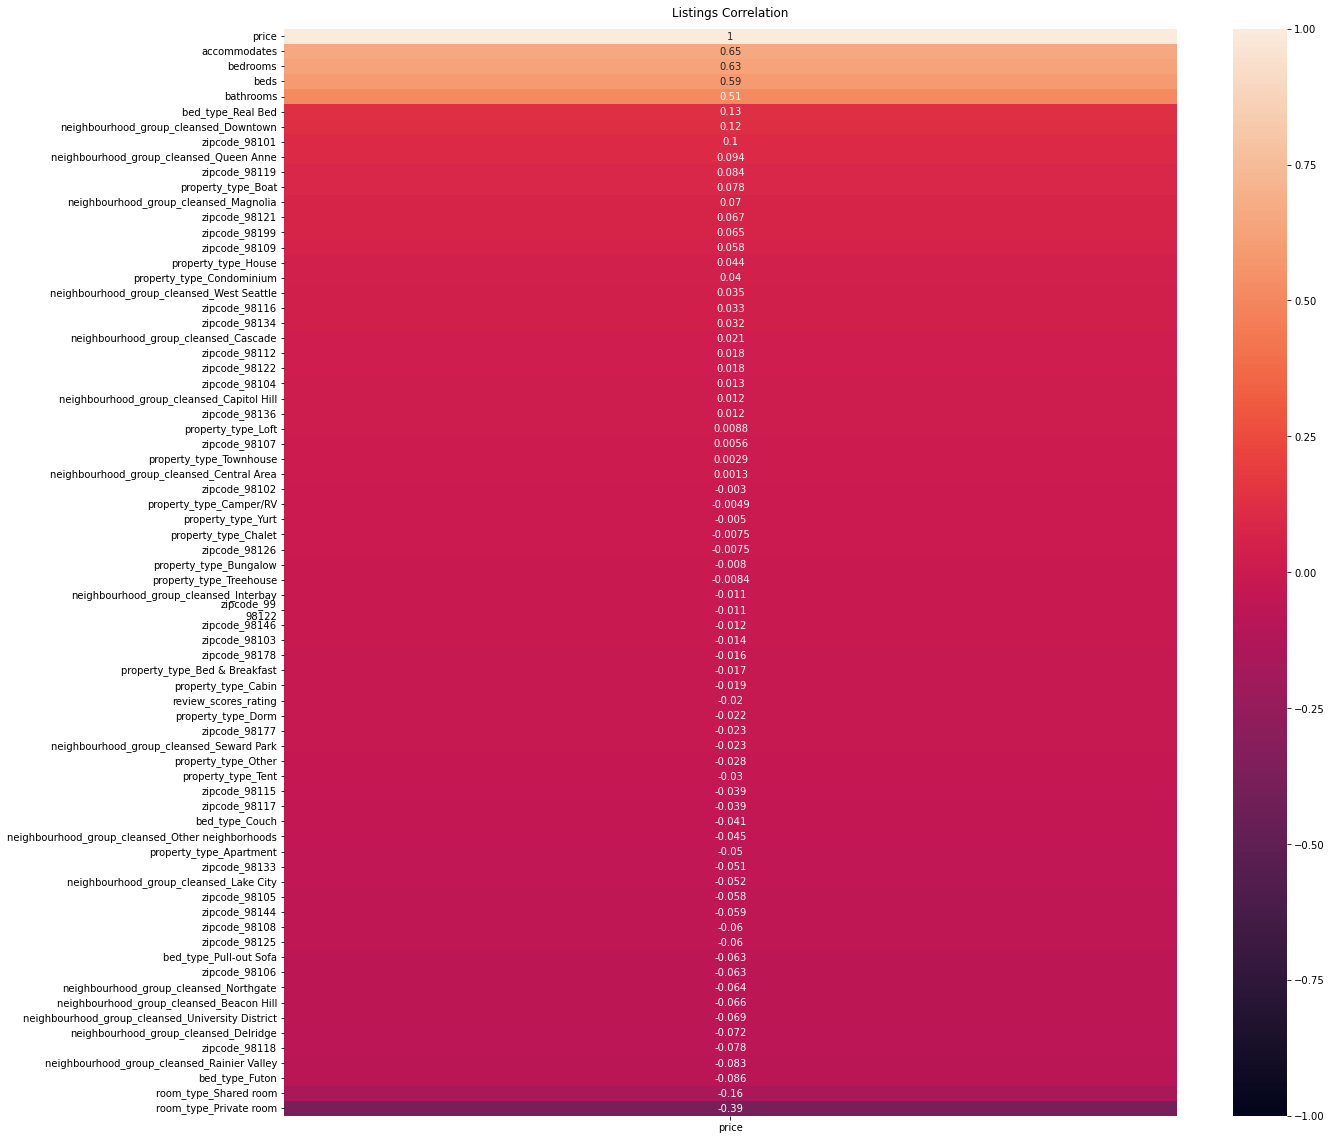

In [9]:
#Build a heatmap to show the correlation impacts of all featues against pricing
import seaborn as sns
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(df_new.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Listings Correlation', fontdict={'fontsize':12}, pad=12);


We can see 4 features (accommodates, bedrooms, beds and bathrooms) all have correlation scores higher than 0.5 (50%), which suggests these are the more relevant features if we want to predict Seattle Airbnb price. 

In [17]:
#Display the correlation factors in order in a tabular form
corr_df = df_new.corr()[['price']].sort_values(by='price', ascending=False)
corr_df.head(-20)

,price
price,1.000000
accommodates,0.652218
bedrooms,0.626891
beds,0.588455
bathrooms,0.512133
bed_type_Real Bed,0.126372
neighbourhood_group_cleansed_Downtown,0.117590
neighbourhood_group_cleansed_Queen Anne,0.093789
zipcode_98119,0.083945
property_type_Boat,0.078404


## Modeling

I tested 3 different models including Linear Regression, Random Forest and Gradient Boosting to predict pricing based on the 4 features. 

Graident Boosting performed the best out of the 3 based on the R2 value. 

In [19]:
# Testing out a Linear Regression model to predict pricing

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

price_model = df_new[['price', 'accommodates', 'bedrooms', 'beds','bathrooms']].copy()

price_model = price_model.fillna(0)

X = price_model[['accommodates', 'bedrooms', 'beds', 'bathrooms']]
y = price_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_test_predict = linear_reg.predict(X_test)

"The R2 value for the model is {} on {} value.".format(r2_score(y_test, y_test_predict), len(y_test))

'The R2 value for the model is 0.5056340307675573 on 955 value.'

In [20]:
# Testing out a random forecast model 
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)

"The R2 value for the model is {} on {} value.".format(r2_score(y_test, y_test_predict), len(y_test))

'The R2 value for the model is 0.4716405441599061 on 955 value.'

In [21]:
# Testing out a Gradient Boost model


from sklearn.ensemble import GradientBoostingRegressor 

gbr_params ={'n_estimators':1000, 
             'max_depth':3, 
             'min_samples_split':5, 
             'learning_rate': 0.01, 
             'loss':'squared_error'}

gbr = GradientBoostingRegressor(**gbr_params)
gbr.fit(X_train, y_train)

y_test_predict = gbr.predict(X_test)

"The R2 value for the model is {} on {} value.".format(r2_score(y_test, y_test_predict), len(y_test))

'The R2 value for the model is 0.5128772187580086 on 955 value.'